In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "white")

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv("dataset/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Preprocessing

### Process Review Texts

In [3]:
sample_review = df["review"].iloc[0]
sample_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

After taking a look at this sample review, I decided to process the review texts through several steps:
1. Remove HTML contents such as "<br \/>"
2. Remove punctuations
4. Turn all letters to lowercase
3. Remove stopwords
4. Apply Lemmatization

In [4]:
def process_review(review):
    
    # Remove HTML contents
    soup = BeautifulSoup(review, "html.parser")
    html_parsed = soup.get_text()
    
    # Remove punctuations
    punct_removed = re.sub(r"[^\w]", " ", html_parsed)
    
    # Turn all letters to lowercase
    lowercase = punct_removed.lower()
    
    # Remove stopwords
    word_lst = lowercase.split()
    stopword_removed = [word for word in word_lst if word not in set(stopwords.words("english"))]
    
    # Lemmatization
    lem = WordNetLemmatizer()
    lemmatized = [lem.lemmatize(word) for word in stopword_removed]
    res = " ".join(lemmatized)

    return res

In [5]:
process_review(sample_review)

'one reviewer mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz

In [6]:
df["review"] = df["review"].apply(process_review)
df.head()

,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive


### Encode Labels

In [7]:
df["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [8]:
df["sentiment"].iloc[:5]

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

In [9]:
label_encoder = LabelEncoder()
df["sentiment"] = label_encoder.fit_transform(df["sentiment"])
classes = label_encoder.classes_
df["sentiment"].iloc[:5]

0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64

### Train Test Split

In [10]:
reviews = np.array([review for review in df["review"]])
labels = np.array([label for label in df["sentiment"]])

In [11]:
train_reviews, test_reviews, train_labels, test_labels = train_test_split(reviews, labels, test_size = 0.2, stratify = labels)

### Tokenization

In [12]:
oov_tok = "<OOV>"
padding_type = "post"
max_length = 120

In [13]:
tokenizer = Tokenizer(oov_token = oov_tok)
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [14]:
train_sequences = tokenizer.texts_to_sequences(train_reviews)
train_data = pad_sequences(train_sequences, padding = padding_type, maxlen = max_length)

test_sequences = tokenizer.texts_to_sequences(test_reviews)
test_data = pad_sequences(test_sequences, padding = padding_type, maxlen = max_length)

## Models

In [15]:
def plot_history(history):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [16]:
def plot_confusion_matrix(pred):
    pred = np.round(pred)
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    cm = confusion_matrix(test_labels, pred)
    sns.heatmap(cm, annot = True, cbar = False, fmt="1d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes, rotation=0)
    plt.show()

In [17]:
def test_accuracy(pred):
    acc = accuracy_score(test_labels, np.round(pred))
    print("Test accuracy is", acc)

In [18]:
embedding_dim = 100
num_epochs = 10
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 2)]

### Word Embedding

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = "relu", kernel_regularizer = "l2"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          8524500   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                2424      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,526,949
Trainable params: 8,526,949
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(train_data, train_labels, 
                    epochs = num_epochs, verbose = 2, 
                    callbacks = my_callbacks, 
                    validation_split = 0.25)

pred = model.predict(test_data)

Epoch 1/10
938/938 - 103s - loss: 0.5788 - accuracy: 0.7809 - val_loss: 0.3912 - val_accuracy: 0.8717
Epoch 2/10
938/938 - 102s - loss: 0.3443 - accuracy: 0.8938 - val_loss: 0.3338 - val_accuracy: 0.8813
Epoch 3/10
938/938 - 105s - loss: 0.2738 - accuracy: 0.9224 - val_loss: 0.3139 - val_accuracy: 0.8848
Epoch 4/10
938/938 - 104s - loss: 0.2290 - accuracy: 0.9403 - val_loss: 0.3173 - val_accuracy: 0.8826
Epoch 5/10
938/938 - 105s - loss: 0.1939 - accuracy: 0.9541 - val_loss: 0.3176 - val_accuracy: 0.8844


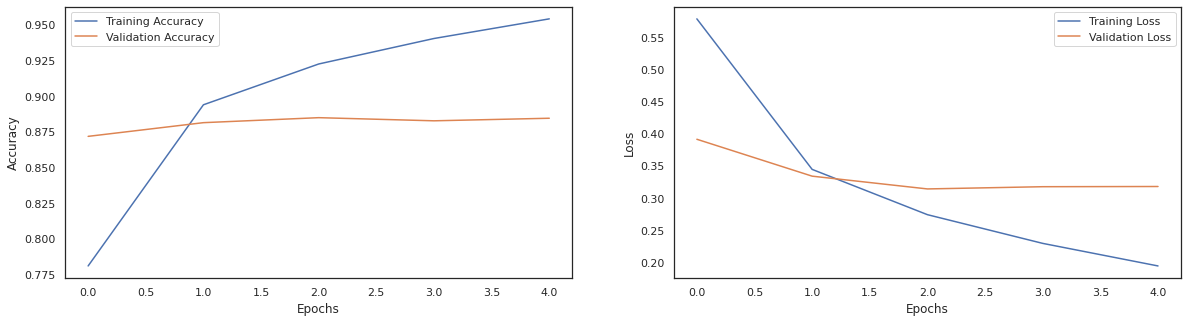

In [21]:
plot_history(history)

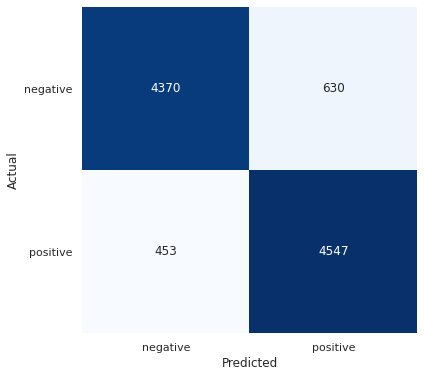

In [22]:
plot_confusion_matrix(pred)

In [23]:
test_accuracy(pred)

Test accuracy is 0.8917


### Bidirectional LSTM

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer = "l2")),
    tf.keras.layers.Dense(24, activation = "relu", kernel_regularizer = "l2"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 100)          8524500   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 8,612,101
Trainable params: 8,612,101
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(train_data, train_labels, 
                    epochs = num_epochs, verbose = 2, 
                    callbacks = my_callbacks, 
                    validation_split = 0.25)

pred = model.predict(test_data)

Epoch 1/10
938/938 - 176s - loss: 0.8066 - accuracy: 0.6005 - val_loss: 0.4271 - val_accuracy: 0.8441
Epoch 2/10
938/938 - 174s - loss: 0.3045 - accuracy: 0.8936 - val_loss: 0.3156 - val_accuracy: 0.8798
Epoch 3/10
938/938 - 174s - loss: 0.1718 - accuracy: 0.9513 - val_loss: 0.3378 - val_accuracy: 0.8782
Epoch 4/10
938/938 - 175s - loss: 0.1101 - accuracy: 0.9743 - val_loss: 0.4096 - val_accuracy: 0.8707


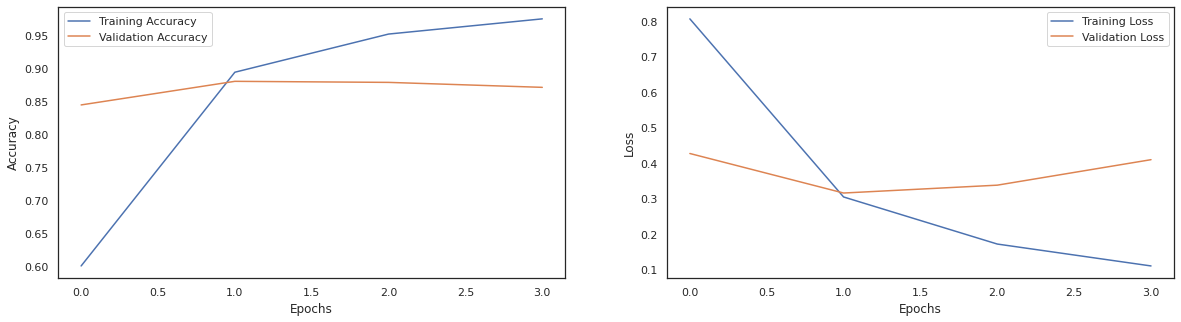

In [26]:
plot_history(history)

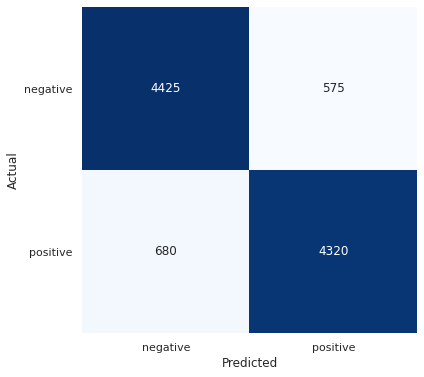

In [27]:
plot_confusion_matrix(pred)

In [28]:
test_accuracy(pred)

Test accuracy is 0.8745


### GloVe Embeddings

In [29]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-07-12 09:47:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 2607:f8b0:400c:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   133MB/s    in 2.5s    

2020-07-12 09:47:22 (133 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [30]:
embeddings_index = {}

with open("/tmp/glove.6B.100d.txt") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = "float32")
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation = "relu"),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation = "relu"), 
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 100)          8524500   
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 8,625,733
Trainable params: 101,233
Non-trainable params: 8,524,500
______________________________________

In [32]:
history = model.fit(train_data, train_labels, 
                    epochs = num_epochs, verbose = 2, 
                    callbacks = my_callbacks, 
                    validation_split = 0.25)

pred = model.predict(test_data)

Epoch 1/10
938/938 - 34s - loss: 0.4519 - accuracy: 0.7823 - val_loss: 0.3910 - val_accuracy: 0.8240
Epoch 2/10
938/938 - 33s - loss: 0.3330 - accuracy: 0.8540 - val_loss: 0.3462 - val_accuracy: 0.8461
Epoch 3/10
938/938 - 32s - loss: 0.2780 - accuracy: 0.8830 - val_loss: 0.3729 - val_accuracy: 0.8275
Epoch 4/10
938/938 - 33s - loss: 0.2264 - accuracy: 0.9084 - val_loss: 0.3481 - val_accuracy: 0.8508


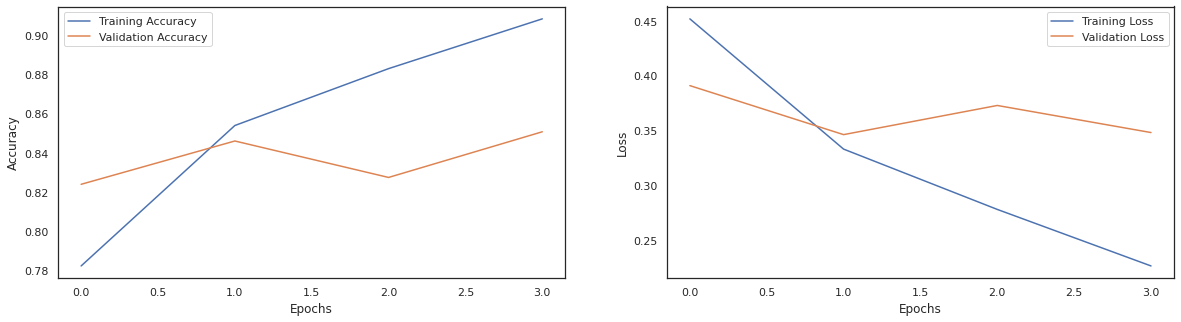

In [33]:
plot_history(history)

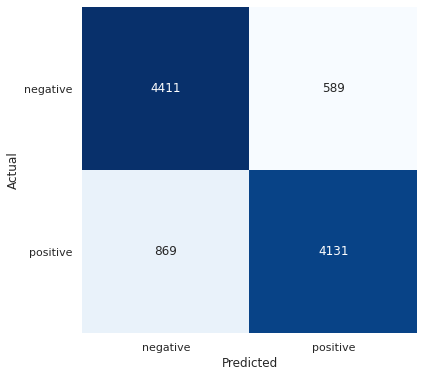

In [34]:
plot_confusion_matrix(pred)

In [35]:
test_accuracy(pred)

Test accuracy is 0.8542
